In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings

from tqdm import tqdm

import umap

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

warnings.filterwarnings('ignore')

In [63]:
from dataset import *
from torchvision.transforms import Compose
transform=Compose([Reshape2DField(), ToTensor()])

tb_logs = '/project/vitelli/jonathan/REDO_fruitfly/tb_logs'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
def agg_loader(model, loader, model_kwargs):
    with torch.no_grad():
        params = []
        logvars = []
        y0s = []
        ys = []
        for batch in tqdm(loader):
            if isinstance(input, list):
                x = torch.cat([batch[i] for i in model_kwargs['input']], axis=-3).to(device)
            else:
                x = batch[model_kwargs['input']].to(device)
            y0 = batch[model_kwargs['output']].to(device)
            y, pl = model(x.to(device))
            y0s.append(y0.cpu().numpy())
            ys.append(y.cpu().numpy())
            params.append(pl[0].cpu().numpy())
            logvars.append(pl[1].cpu().numpy())

        params = np.concatenate(params)
        logvars = np.concatenate(logvars)
        y0 = np.concatenate(y0s)
        y = np.concatenate(ys)
        return params, logvars, y0, y
    
from plot_utils import *
import seaborn as sns

def summary_plot(df, model, dataset, show_tt, show_magnitude=True):
    fig = plt.figure(figsize=(10, 2), dpi=200)
    gs = fig.add_gridspec(2, 5)
    
    ax = fig.add_subplot(gs[:, 0])
    sns.lineplot(data=df, x='time', y='res', color='blue', ax=ax)
    ax.set_ylabel('Error Rate', color='blue')
    ax.set(ylim=[0, 1])
    
    if show_magnitude:
        ax2 = ax.twinx()
        sns.lineplot(data=df, x='time', y='mag', ax=ax2, color='red')
        ax2.set_ylabel('Magnitude', color='red')
        ax2.set_yticks([])
        
    dfi = pd.wide_to_long(
        df.reset_index(), 
        stubnames=['param', 'logvar'], 
        i='index', j='param_num').reset_index(level=1)
        
    param_stats = dfi.groupby('param_num').agg({'param': 'var', 'logvar': lambda x: np.mean(np.exp(x))}).reset_index()
    param_stats['c'] = (param_stats.logvar.max() - param_stats.logvar) / np.ptp(param_stats.logvar)
    param_stats = param_stats.sort_values('logvar').reset_index(drop=True).reset_index()
    
    ax1 = fig.add_subplot(gs[0, 1:3])
    sns.barplot(data=param_stats, x='index', y='param', hue='c', palette='Blues', dodge=False, ax=ax1)
    ax1.legend_.remove()
    ax2 = fig.add_subplot(gs[1, 1:3])
    sns.barplot(data=param_stats, x='index', y='logvar', color='red', ax=ax2)

    ax2.set_ylabel('mean($\sigma^2$)')
    ax2.set_xlabel('Latent Variable')
    ax2.invert_yaxis()
    ax2.set_yticks(ax2.get_yticks()[1:])
    
    fig.subplots_adjust(hspace=0.)
    offset = 0.05
    bb1 = ax1.get_position()
    bb1.x0 = bb1.x0 + offset
    ax1.set_position(bb1)
    bb2 = ax2.get_position()
    bb2.x0 = bb2.x0 + offset
    ax2.set_position(bb2)
    
    with torch.no_grad():
        idx = df[df.set == 'test'].index[show_tt]
        y0 = dataset[idx][output].to(device)[None]
        y, _ = model(y0)    
        plot_fn(fig.add_subplot(gs[:, -2]), y0[0].cpu().numpy())
        plt.title('Experiment')
        plot_fn(fig.add_subplot(gs[:, -1]), y[0].cpu().numpy())
        plt.title('ML')

plt.rcParams['font.size'] = 6
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

def reconstruct(z, model):
    with torch.no_grad():
        z = torch.cuda.FloatTensor(z)
        z = model.params_to_field(z)
        z = F.gelu(z)
        z = z.reshape([z.shape[0], -1, *model.bottleneck_size])
        z = model.decoder(z)
        z = F.interpolate(z, size=[236, 200], mode='bilinear')
        z = z.cpu().numpy()
    return z

def residual(u, v):
    umag = np.linalg.norm(u, axis=-3)                                                 
    vmag = np.linalg.norm(v, axis=-3)                                                 

    uavg = np.sqrt((umag**2).mean(axis=(-2, -1), keepdims=True))                    
    vavg = np.sqrt((vmag**2).mean(axis=(-2, -1), keepdims=True))                    

    res = uavg**2 * vmag**2 + vavg**2 * umag**2 - 2 * uavg * vavg * np.einsum('...ijk,...ijk->...jk', u, v)
    res /= 2 * vavg**2 * uavg**2                                                        
    return res 

def get_results(dataset, checkpoint):
    print(checkpoint['hparams'])
    model = VAE(**checkpoint['hparams'])
    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    model.eval()

    df = dataset.df.copy()
    
    test_df = checkpoint['val_df']
    test_df = pd.merge(df.reset_index(), test_df, how='inner', on=['embryoID', 'time'])
    
    df['set'] = 'train'
    df.loc[test_df['index'], 'set'] = 'test'
    df['time'] = df['time'].astype(int)
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
    params, logvars, y0, y = agg_loader(model, loader, checkpoint['hparams'])
    
    df['res'] = residual(y, y0).mean(axis=(-1, -2))
    df['mag'] = np.linalg.norm(y, axis=1).mean(axis=(-1, -2))
    df = pd.concat([df, 
                pd.DataFrame(params).add_prefix('param'),
                pd.DataFrame(logvars).add_prefix('logvar')], axis=1)
    
    drop_mask = df.embryoID == 202001280915
    df = df[~drop_mask]
    
    print(df.groupby('set').agg({'index_vel': 'count'}))
    
    return model, df

# Variational Autoencoders

In [17]:
vel = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)
cad = AtlasDataset('WT', 'ECad-GFP', 'tensor2D', transform=transform)
sqh = AtlasDataset('WT', 'sqh-mCherry', 'tensor2D', transform=transform)
vcs_dataset = AlignedDataset([vel, cad, sqh], ['vel', 'cad', 'sqh'])

vel = AtlasDataset('WT', 'Runt', 'velocity2D', transform=transform)
runt = AtlasDataset('WT', 'Runt', 'raw2D', transform=transform)
runt_dataset = AlignedDataset([vel, runt], ['vel', 'runt'])

100%|██████████| 6/6 [00:00<00:00, 640.94it/s]


## Flow field

{'lr': 0.0001, 'num_latent': 16, 'stage_dims': [[32, 32], [64, 64], [128, 128], [256, 256, 16]], 'alpha': 0.0, 'in_channels': 2, 'out_channels': 2, 'input': 'vel', 'output': 'vel'}


100%|██████████| 30/30 [00:01<00:00, 15.57it/s]


       index_vel
set             
test          78
train        312


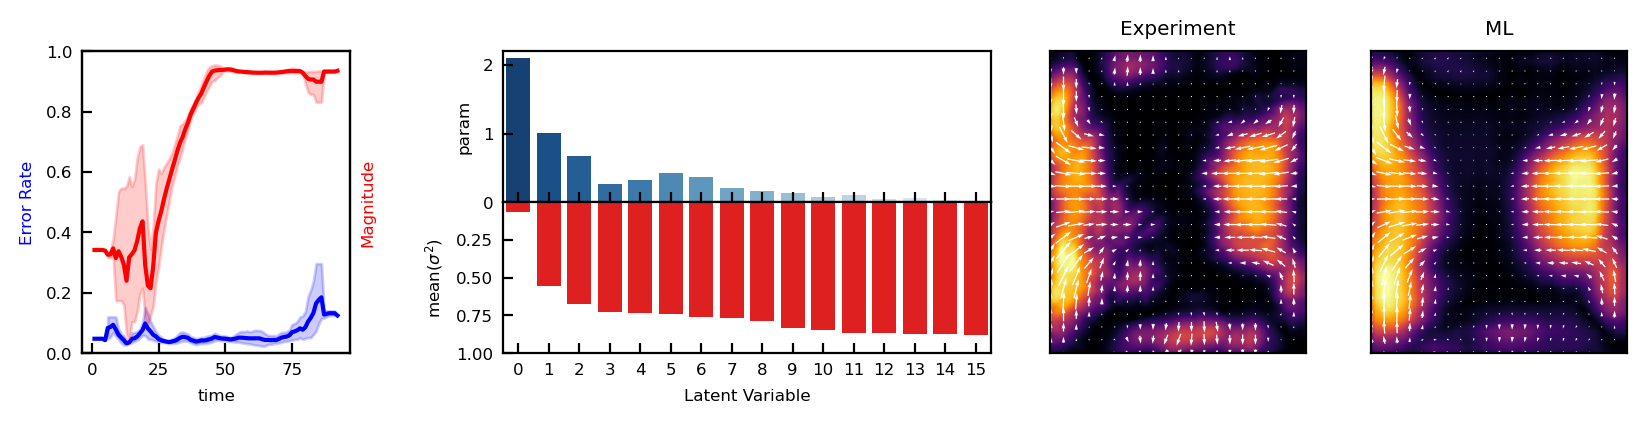

In [126]:
from convnext_models import VAE

C=32
beta=1e-2
log10beta=-1.9
log10beta=-2.3
output = 'vel'

checkpoint = torch.load(
    #os.path.join(tb_logs,'Adam_VAE_%s_%s' % (output, output), 'beta=%g.ckpt' % beta))
    os.path.join(tb_logs,'DisentangledAdam_VAE_%s_%s' % (output, output), 'log10beta=%g.ckpt' % log10beta))

vel_model, vel_df = get_results(vcs_dataset, checkpoint)
plot_fn = plot_vector2D
summary_plot(vel_df, vel_model, vcs_dataset, 0, show_magnitude=True)

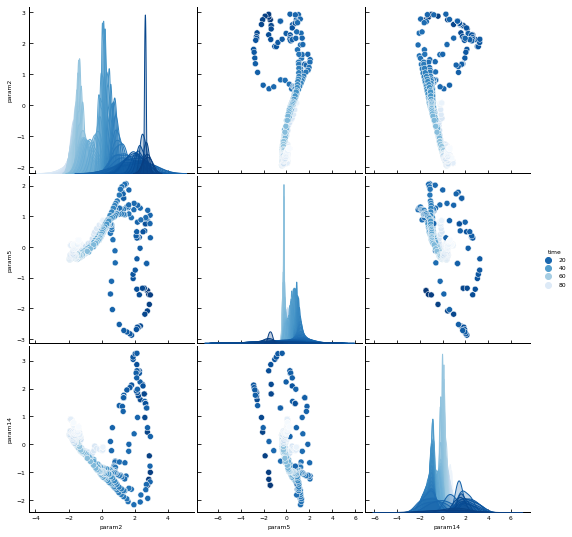

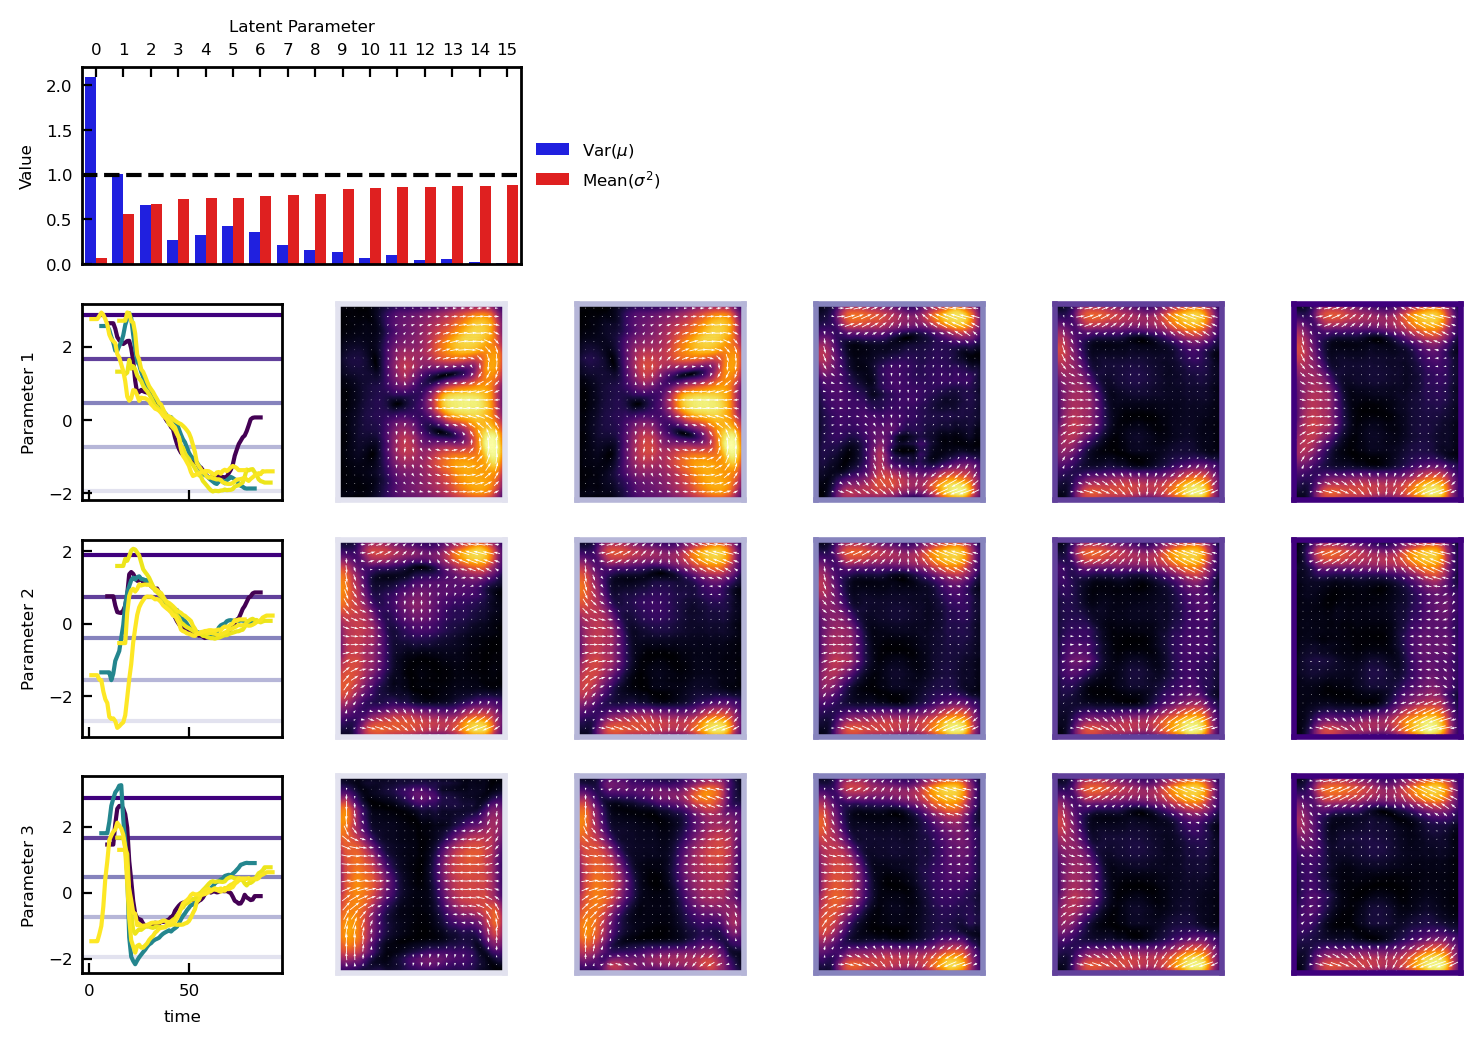

In [131]:
import seaborn as sns
import torch.nn.functional as F
from plot_utils import *

def param_plots(df, model, cutoff=0.05):
    dfi = pd.wide_to_long(
        df.reset_index(), 
        stubnames=['param', 'logvar'], 
        i='index', j='param_num').reset_index(level=1)
    param_stats = dfi.groupby('param_num').agg({
        'param': 'var', 
        'logvar': lambda x: np.mean(np.exp(x))}).reset_index()
    
    keep_params = param_stats.loc[param_stats.logvar / param_stats.param < 1.5, 'param_num'] .values   
    keep_cols = ['param'+str(kp) for kp in keep_params]
    N_params = len(keep_params)
    keep_cols = ['time', 'set'] + keep_cols    
    dfi = df[keep_cols]    

    g = sns.pairplot(
        data=dfi,
        hue='time',
        palette='Blues_r',
    )
    
    N_trav=5
    sp = 1.5
    fig = plt.figure(figsize=(sp*(N_trav+1), sp*(N_params+1)), dpi=200)
    gs = fig.add_gridspec(N_params+1,N_trav+1)
    
    param_stats = param_stats.sort_values('logvar').reset_index(drop=True).reset_index()
    param_stats = param_stats.drop('param_num', axis=1)
    param_stats = param_stats.rename({'param': 'Var($\\mu$)', 'logvar': 'Mean($\\sigma^2$)'}, axis=1)
    param_stats = pd.melt(param_stats, id_vars='index')
    
    ax = fig.add_subplot(gs[0, :2])
    sns.barplot(
        data=param_stats,
        x='index',
        y='value',
        hue='variable',
        ax=ax,
        palette=['blue', 'red']
    )
    ax.axhline(1, color='black', linestyle='--')
    ax.set(xlabel='Latent Parameter', ylabel='Value')
    ax.xaxis.set_label_position("top")
    ax.xaxis.tick_top()
    ax.legend(loc='center left', bbox_to_anchor=[1, 0.5], framealpha=0.)
    
    dfi = pd.wide_to_long(df.reset_index(), stubnames=['param'], i='index', j='param_num').reset_index(level=1)
    param_means = dfi.groupby('param_num')['param'].agg('mean')
    param_means = dfi[dfi.time < 20].groupby('param_num')['param'].agg('mean')
    vmax = None
    for i in range(N_params):
        param_num = keep_params[i]
        ax = fig.add_subplot(gs[i+1, 0])
        data = dfi[dfi.param_num == param_num]
        sns.lineplot(
            data=data,
            x='time',
            y='param',
            hue='embryoID',
            palette='viridis',
            ax=ax,
            legend=False)
        ax.set(ylabel='Parameter %d' % (i+1))
        if i != N_params - 1:
            ax.set(xlabel='', xticklabels=[])
        
        if i > 0:
            param_means = dfi[dfi.time < 20].groupby('param_num')['param'].agg('mean')

        points = param_means.values[None].repeat(N_trav, axis=0)
        r0, r1 = np.percentile(data.param.values, [1, 99])
        points[:, param_num] = np.linspace(0, 1, points.shape[0]) * (r1-r0) + r0
        
        z = reconstruct(points, model)

        colors = plt.cm.Purples(np.linspace(0, 1, points.shape[0]+1))[1:]    

        if vmax is None:
            vmax = np.max(np.linalg.norm(z, axis=1))

        for j in range(len(colors)):
            a = fig.add_subplot(gs[i+1, j+1])
            plot_fn(a, z[j], vmax=vmax)
            ax.axhline(points[j, param_num], zorder=-1, color=colors[j])
            for spine in a.spines.values():
                spine.set_edgecolor(colors[j])
                spine.set_linewidth(2)
                
plt.rcParams['axes.linewidth'] = 1.
param_plots(vel_df, vel_model)

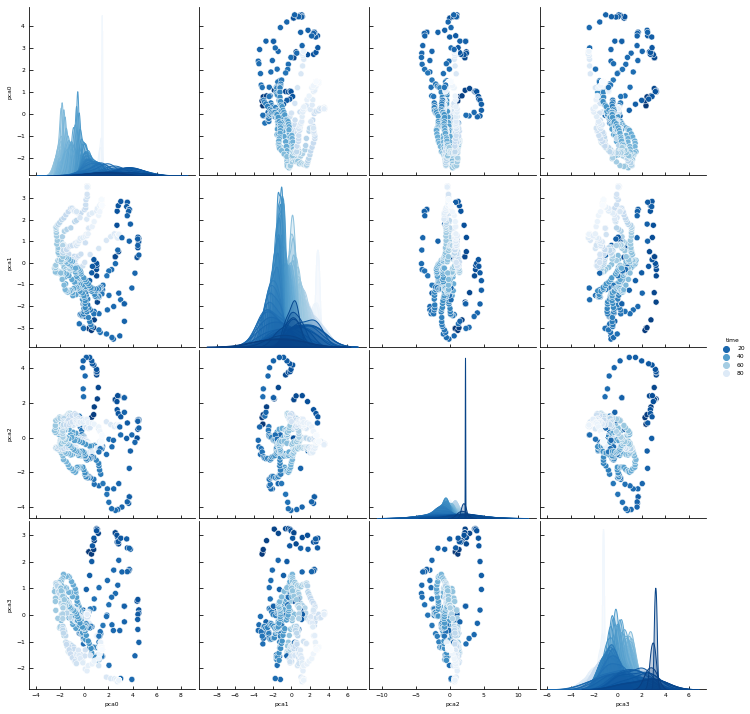

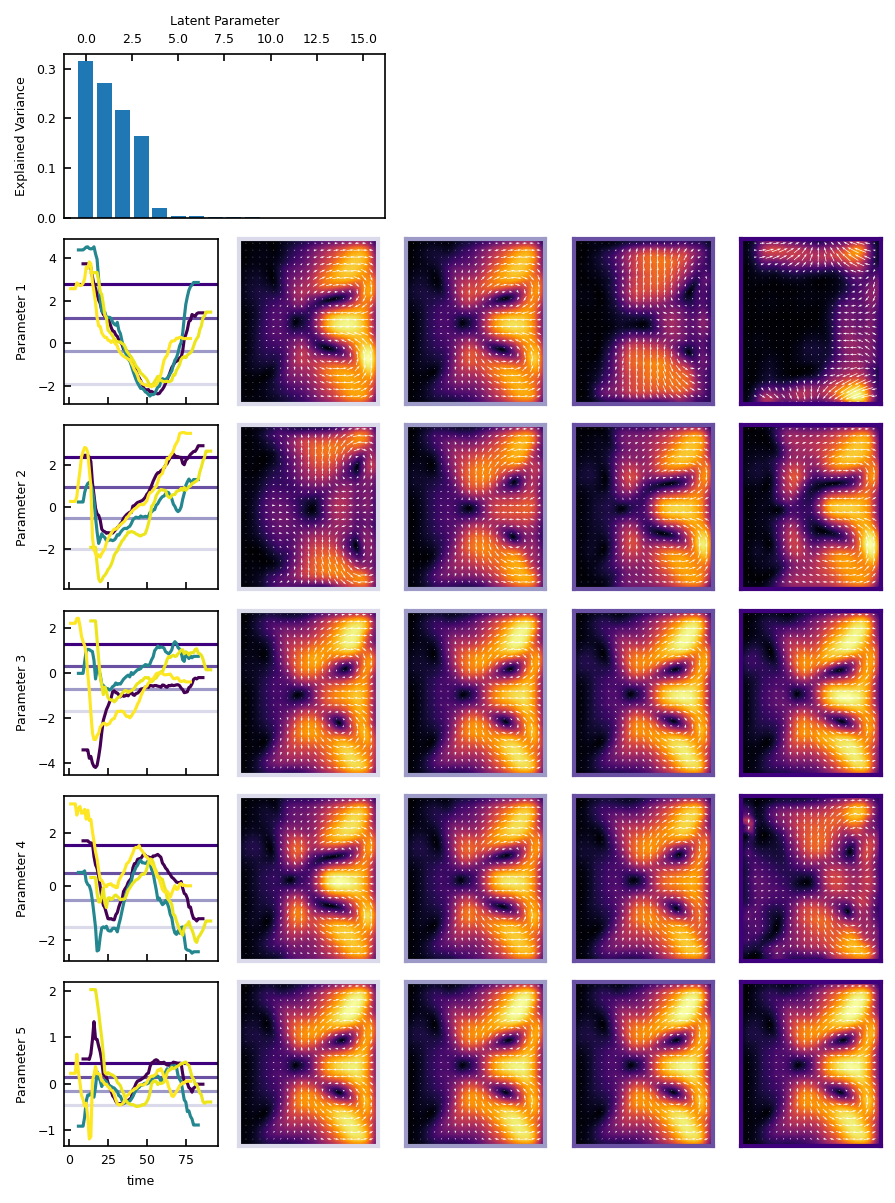

In [125]:
import seaborn as sns
from sklearn.decomposition import PCA
import torch.nn.functional as F
from plot_utils import *

def reconstruct(z, model):
    with torch.no_grad():
        z = torch.cuda.FloatTensor(z)
        z = model.params_to_field(z)
        z = F.gelu(z)
        z = z.reshape([z.shape[0], -1, *model.bottleneck_size])
        z = model.decoder(z)
        z = F.interpolate(z, size=[236, 200], mode='bilinear')
        z = z.cpu().numpy()
    return z

def pca_pairplot(df, cutoff=0.05):
    n_components=16
    pca = PCA(n_components=n_components)

    train_mask = df.set == 'train'
    data = df.filter(like='param').values

    pca.fit(data[train_mask])
    values = pca.transform(data)

    values = values[:, pca.explained_variance_ratio_ > cutoff]

    dfi = pd.concat([pd.DataFrame(values).add_prefix('pca'), df[['time', 'set']].reset_index(drop=True)], axis=1)
    g = sns.pairplot(
        data=dfi,
        hue='time',
        palette='Blues_r',
    )
    
def pca_time_plot(df, model):
    n_components=16
    pca = PCA(n_components=n_components)
    
    train_mask = df.set == 'train'
    data = df.filter(like='param').values
    
    pca.fit(data[train_mask])
    values = pca.transform(data)
        
    cutoff = 0.02
    values = values[:, pca.explained_variance_ratio_ > cutoff]

    fig = plt.figure(figsize=(6, 8), dpi=150)
    gs = fig.add_gridspec(values.shape[1]+1, 5)

    ax = fig.add_subplot(gs[0, :2])
    ax.bar(np.arange(n_components), pca.explained_variance_ratio_)
    ax.set(xlabel='Latent Parameter', ylabel='Explained Variance')
    ax.xaxis.set_label_position("top")
    ax.xaxis.tick_top()
    
    dfi = pd.concat([df, pd.DataFrame(values).add_prefix('pca')], axis=1).reset_index()
    dfi = pd.wide_to_long(dfi, stubnames=['pca'], i='index', j='param_num').reset_index(level=1)
    
    for i in range(values.shape[1]):
        ax = fig.add_subplot(gs[i+1, 0])
        sns.lineplot(
            data=dfi[dfi.param_num==i],
            x='time',
            y='pca',
            hue='embryoID',
            palette='viridis',
            ax=ax,
            legend=False)
        ax.set(ylabel='Parameter %d' % (i+1))
        if i != values.shape[1] - 1:
            ax.set(xlabel='', xticklabels=[])
        
        points = np.zeros([gs.ncols-1, pca.n_components])
        points[:, :values.shape[1]] = np.mean(values, axis=0, keepdims=True)
        r0, r1 = np.percentile(values[:, i], [10, 90])
        points[:, i] = np.linspace(0, 1, points.shape[0]) * (r1-r0) + r0
        

        z = pca.inverse_transform(points)
        z = reconstruct(z, model)

        colors = plt.cm.Purples(np.linspace(0, 1, points.shape[0]+1))[1:]    

        vmax = np.max(np.linalg.norm(z, axis=1))

        for j in range(len(colors)):
            a = fig.add_subplot(gs[i+1, j+1])
            plot_fn(a, z[j], vmax=vmax)
            ax.axhline(points[j, i], zorder=-1, color=colors[j])
            for spine in a.spines.values():
                spine.set_edgecolor(colors[j])
                spine.set_linewidth(2)
            
    plt.tight_layout()
    
pca_pairplot(vel_df)
pca_time_plot(vel_df, vel_model)

## Myosin field

{'lr': 0.0001, 'num_latent': 16, 'stage_dims': [[32, 32], [64, 64], [128, 128], [256, 256, 16]], 'alpha': 0.0, 'in_channels': 4, 'out_channels': 4, 'input': 'sqh', 'output': 'sqh', 'beta': 0.001}


100%|██████████| 30/30 [00:02<00:00, 14.62it/s]


       index_vel
set             
test          78
train        312


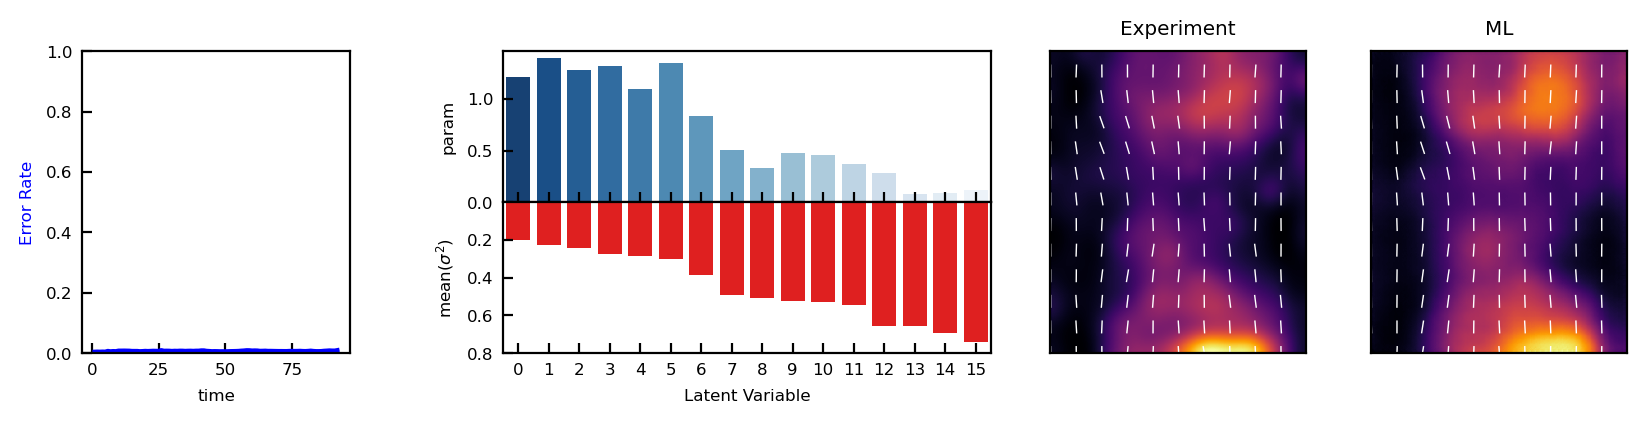

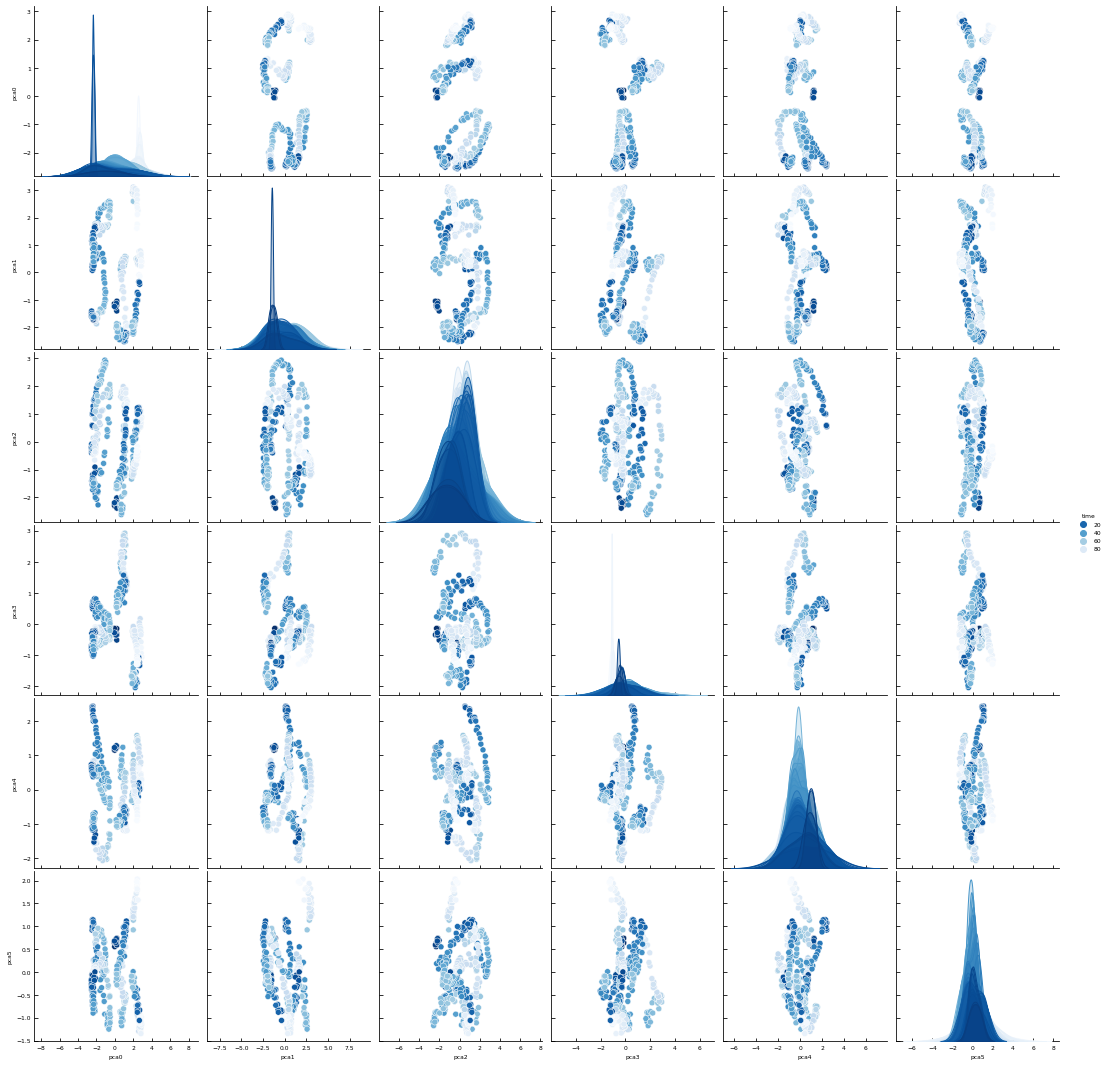

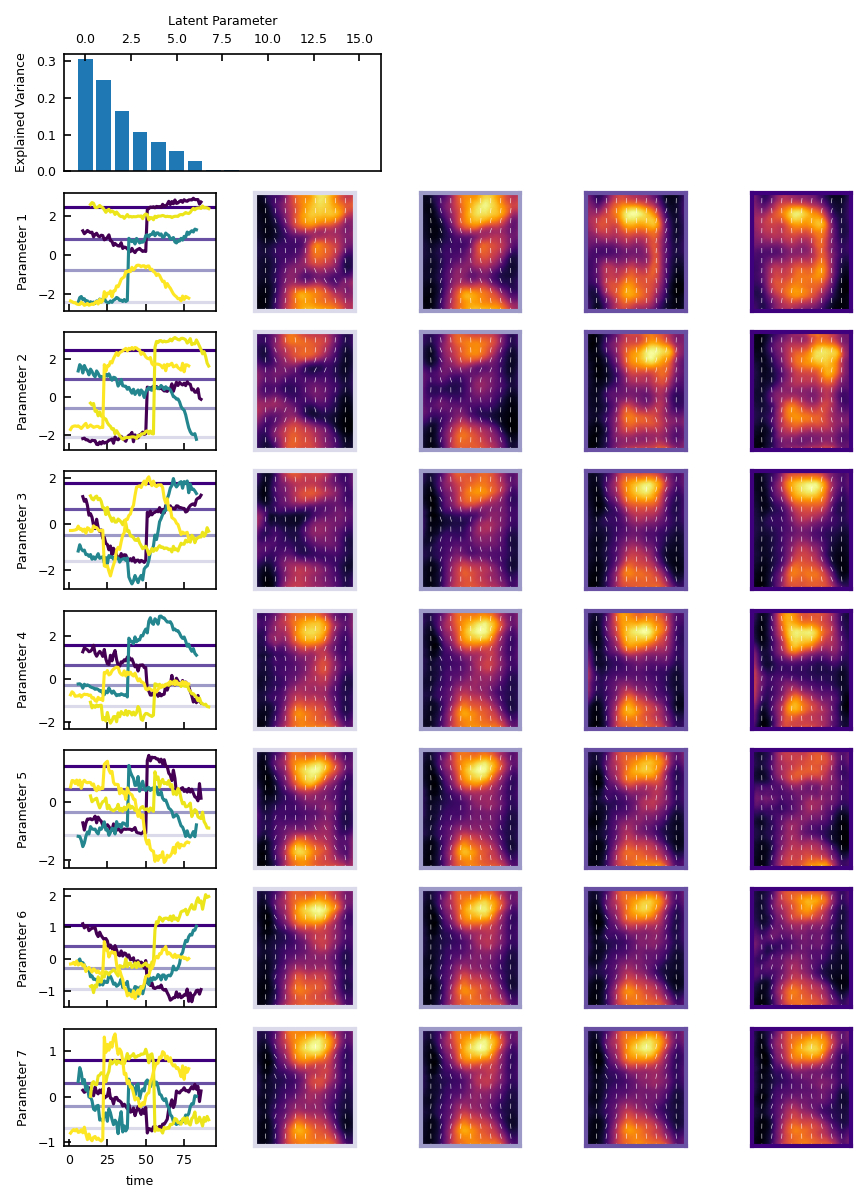

In [21]:
beta=1e-3
output = 'sqh'

checkpoint = torch.load(
    os.path.join(tb_logs,'Adam_VAE_%s_%s' % (output, output), 'beta=%g.ckpt' % beta))

sqh_model, sqh_df = get_results(vcs_dataset, checkpoint)
plot_fn = plot_tensor2D
summary_plot(sqh_df, sqh_model, vcs_dataset, 5, show_magnitude=False)
pairplot(sqh_df)
time_plot(sqh_df, sqh_model)

{'lr': 0.0001, 'num_latent': 16, 'stage_dims': [[32, 32], [64, 64], [128, 128], [256, 256, 16]], 'alpha': 0.0, 'in_channels': 4, 'out_channels': 4, 'input': 'cad', 'output': 'cad', 'beta': 0.001}


100%|██████████| 30/30 [00:02<00:00, 14.26it/s]


       index_vel
set             
test          80
train        310


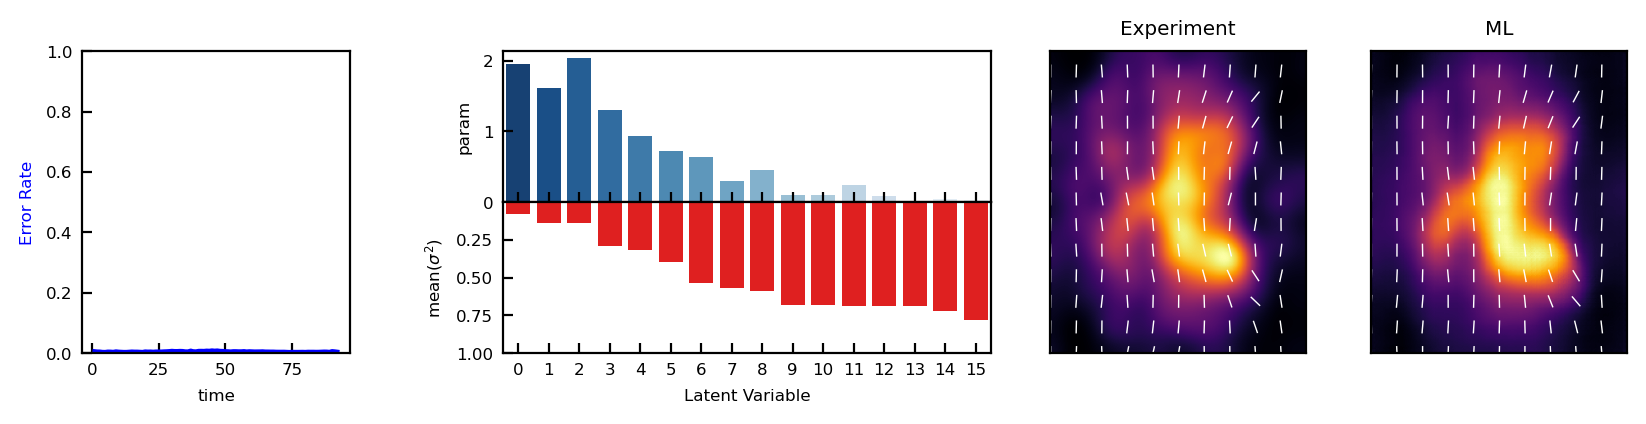

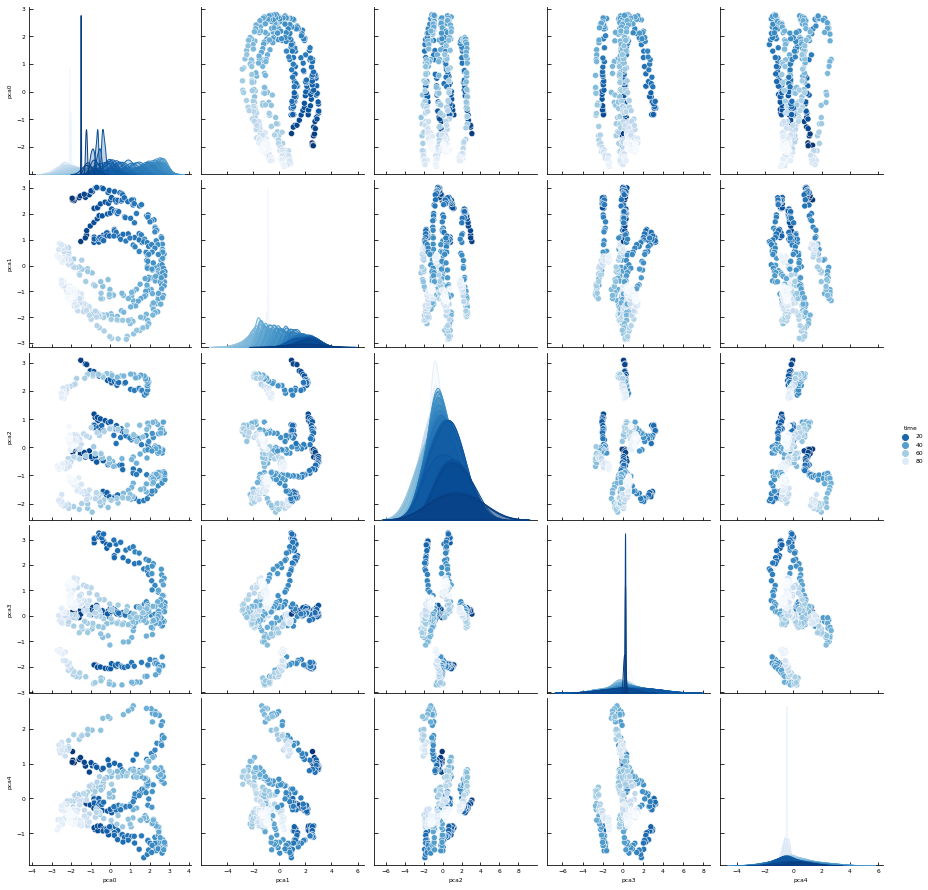

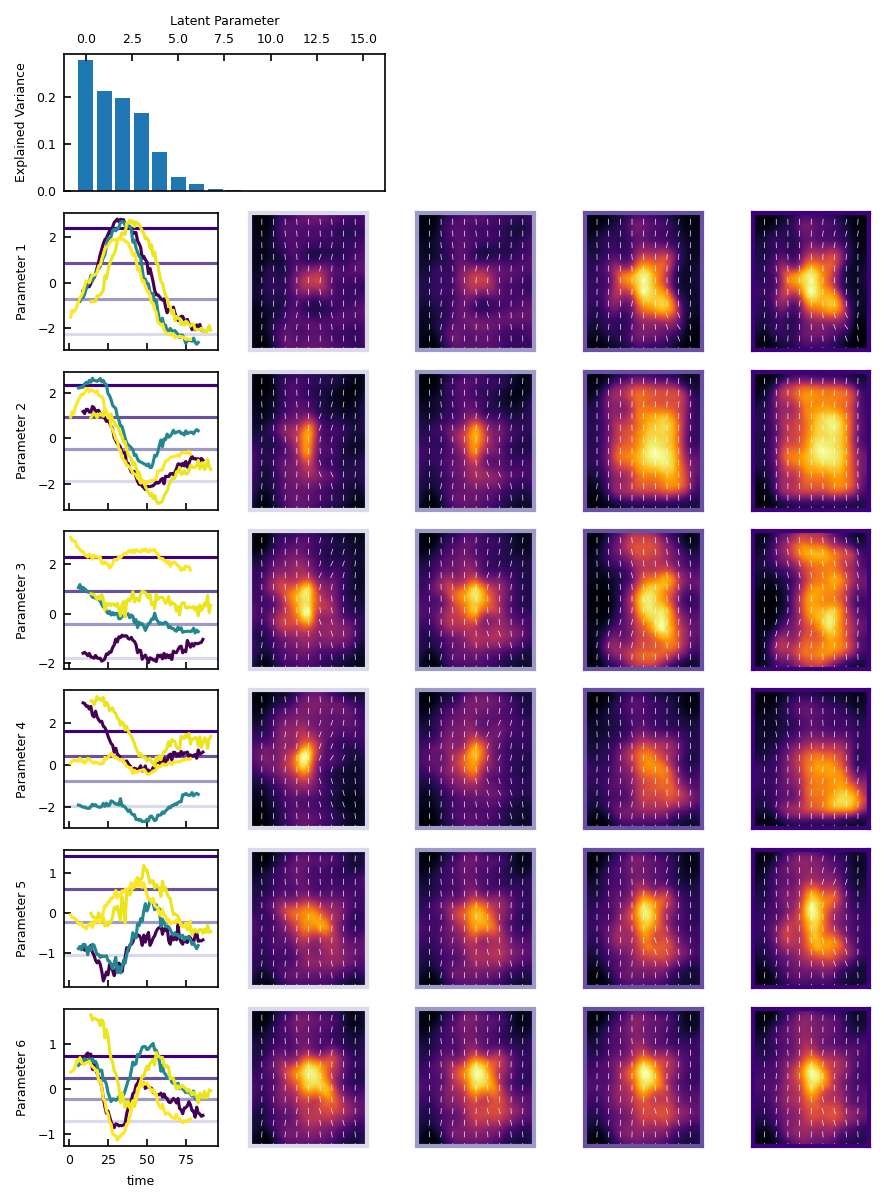

In [24]:
beta=1e-3
output = 'cad'

checkpoint = torch.load(
    os.path.join(tb_logs,'Adam_VAE_%s_%s' % (output, output), 'beta=%g.ckpt' % beta))

cad_model, cad_df = get_results(vcs_dataset, checkpoint)
plot_fn = plot_tensor2D
summary_plot(cad_df, cad_model, vcs_dataset, 5, show_magnitude=False)
pairplot(cad_df)
time_plot(cad_df, cad_model)

{'lr': 0.0001, 'num_latent': 16, 'stage_dims': [[32, 32], [64, 64], [128, 128], [256, 256, 16]], 'alpha': 0.0, 'in_channels': 1, 'out_channels': 1, 'input': 'runt', 'output': 'runt', 'beta': 1e-05}


100%|██████████| 32/32 [00:01<00:00, 19.13it/s]


       index_vel
set             
test          99
train        399


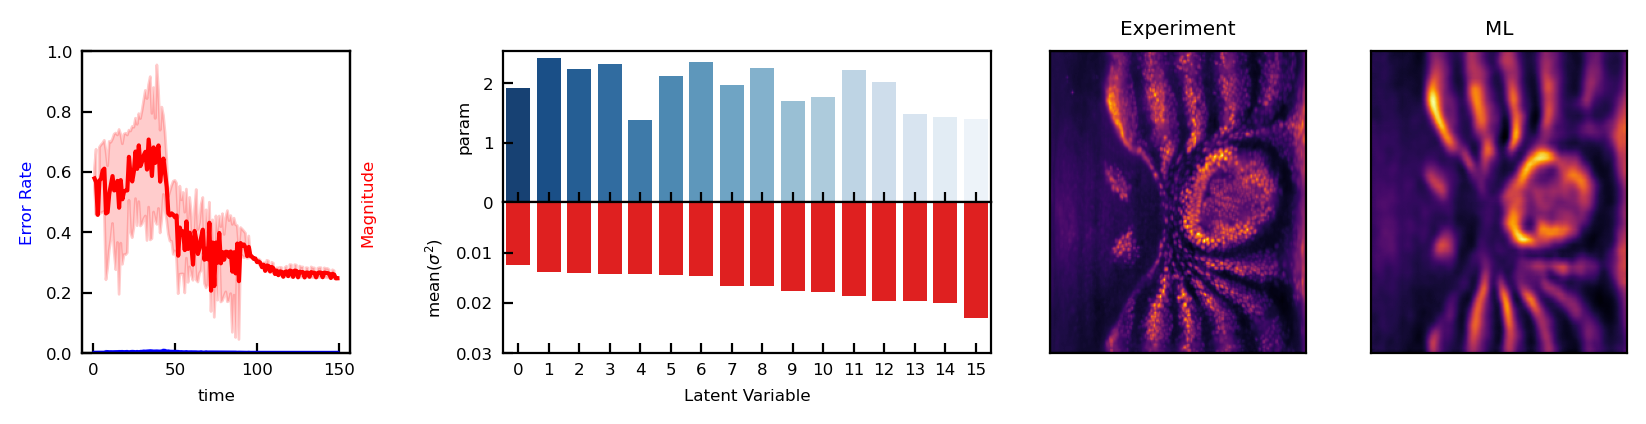

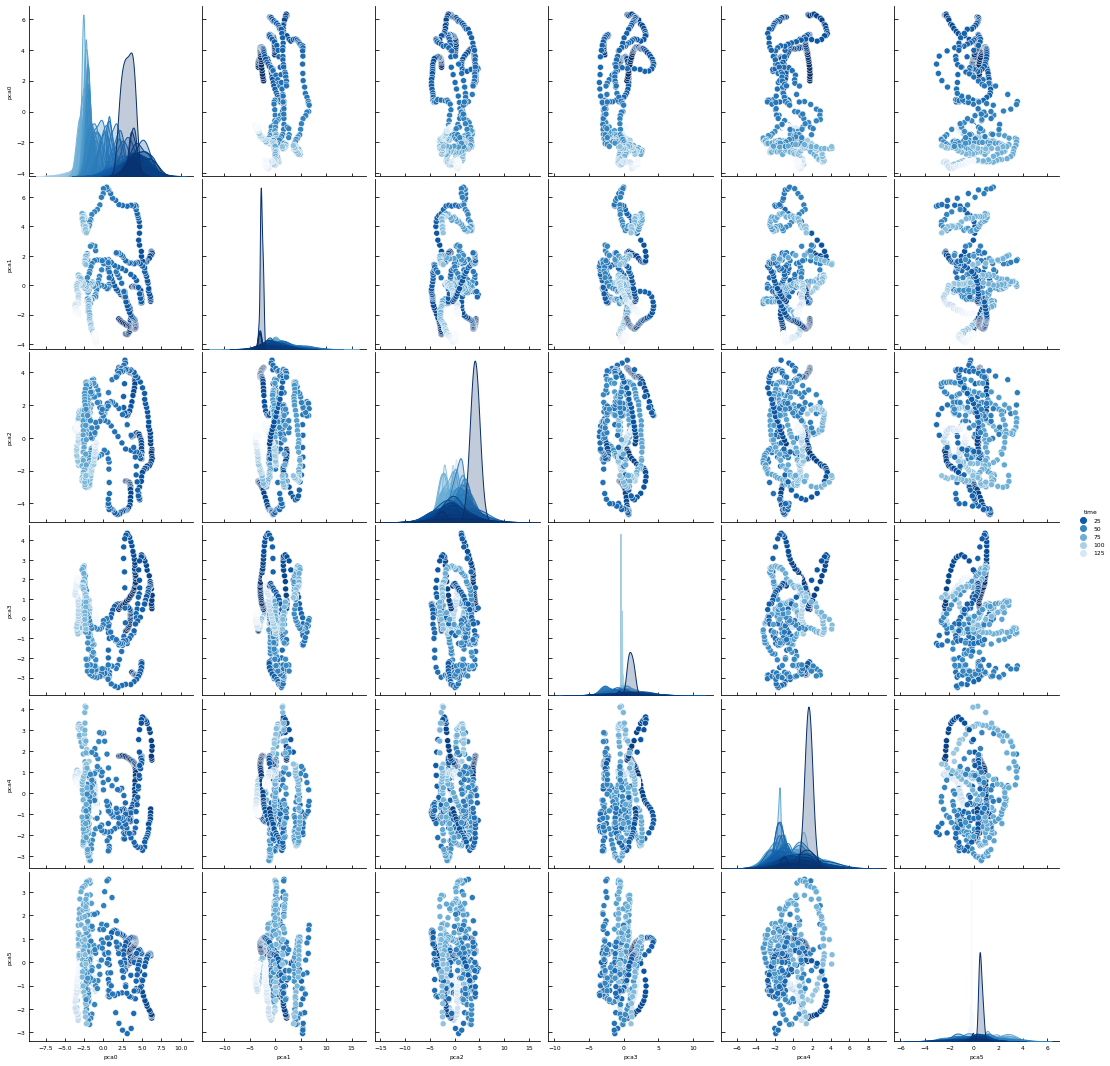

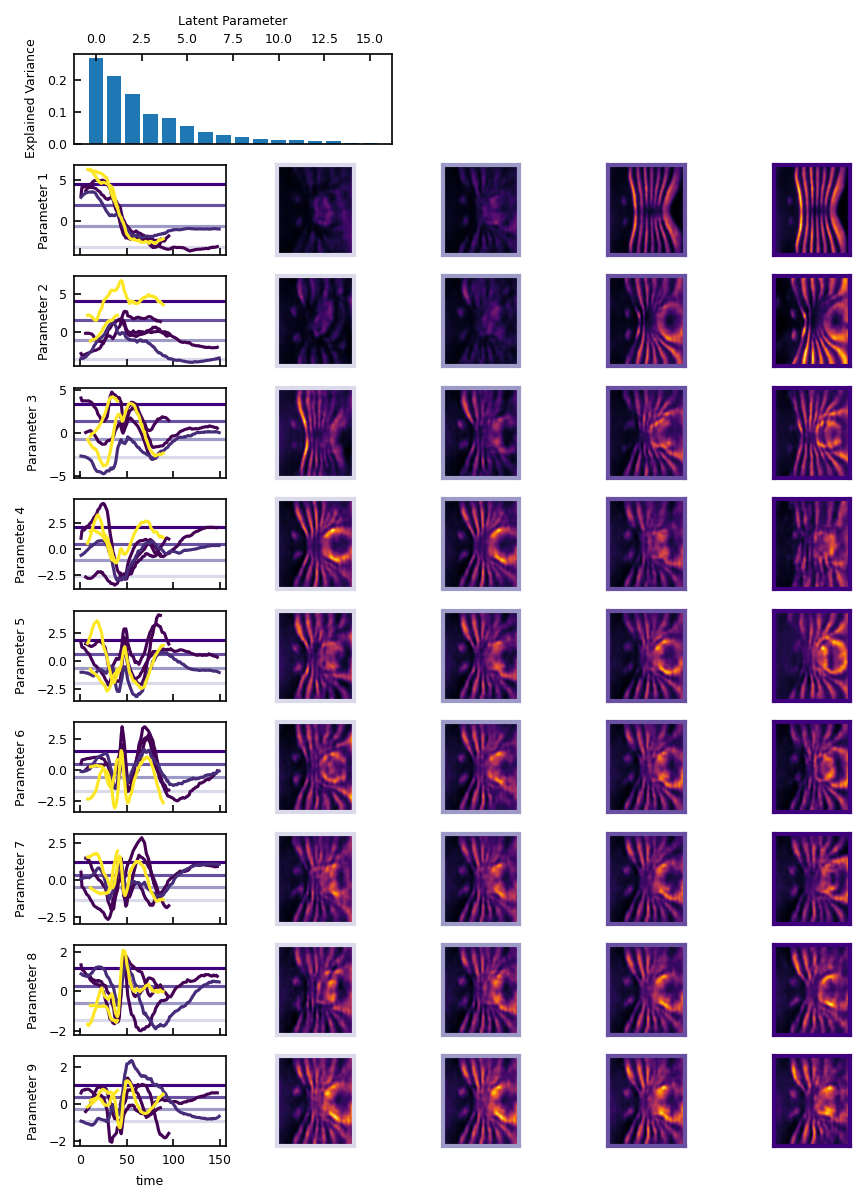

In [54]:
beta=1e-5
output = 'runt'

checkpoint = torch.load(
    os.path.join(tb_logs,'Adam_VAE_%s_%s' % (output, output), 'beta=%g.ckpt' % beta))

plot_fn = color_2D
runt_model, runt_df = get_results(runt_dataset, checkpoint)
summary_plot(runt_df, runt_model, runt_dataset, 10, show_magnitude=True)
pairplot(runt_df)
time_plot(runt_df, runt_model)